In [1]:
#help from https://ipython-books.github.io/103-computing-the-autocorrelation-of-a-time-series/

from zipfile import ZipFile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime
from statsmodels.tsa.stattools import adfuller

with ZipFile('data/babies.zip', 'r') as zipObj:
    zipObj.extractall('data/babies')

In [2]:
files = [file for file in os.listdir('data/babies')
        if file.startswith('yob')]

In [3]:
years = np.array(sorted([int(file[3:7]) for file in files]))

In [4]:
data = {year:
        pd.read_csv('data/babies/yob%d.txt' % year,
                    index_col=0, header=None,
                    names=['First name',
                           'Gender',
                           'Number'])
        for year in years}

In [5]:
data[2000]

,Gender,Number
First name,,
Emily,F,25953
Hannah,F,23078
Madison,F,19967
Ashley,F,17996
Sarah,F,17691
...,...,...
Zeph,M,5
Zeven,M,5
Ziggy,M,5


In [6]:
def get_value(name, gender, year):
    """Return the number of babies born a given year,
    with a given gender and a given name."""
    dy = data[year]
    try:
        return dy[dy['Gender'] == gender] \
                 ['Number'][name]
    except KeyError:
        return 0
    
def get_evolution(name, gender):
    """Return the evolution of a baby name over
    the years."""
    return np.array([get_value(name, gender, year)
                     for year in years])

In [7]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

In [8]:
def autocorr_name(name, gender, color, axes=None):
    x = get_evolution(name, gender)
    z = autocorr(x)

    # Evolution of the name.
    axes[0].plot(years, x, '-o' + color,
                 label=name)
    axes[0].set_title("Baby names")
    axes[0].legend()

    # Autocorrelation.
    axes[1].plot(z / float(z.max()),
                 '-' + color, label=name)
    axes[1].legend()
    axes[1].set_title("Autocorrelation")

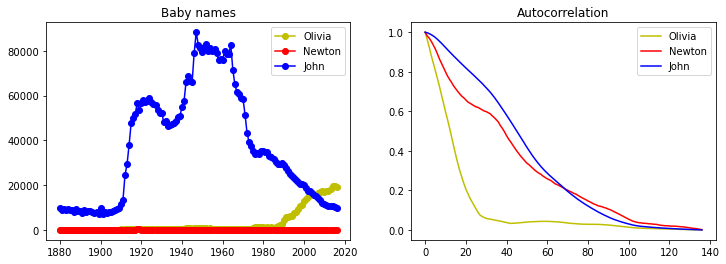

In [9]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))
autocorr_name('Olivia', 'F', 'y', axes = axes)
autocorr_name('Newton', 'M', 'r', axes = axes)
autocorr_name('John', 'M', 'b', axes = axes)

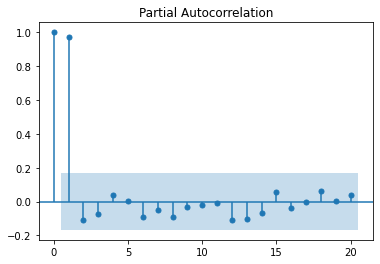

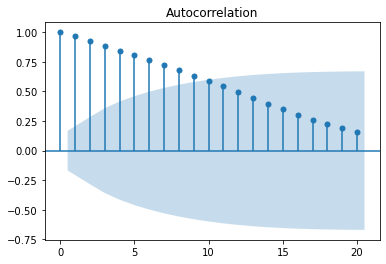

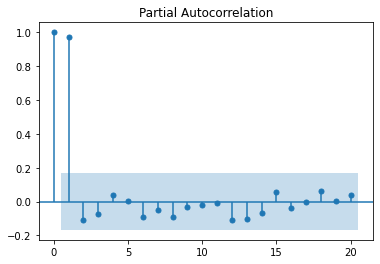

In [10]:
#Olivia

dfo = get_evolution('Olivia', 'F')

plot_acf(dfo, lags=20)
plot_pacf(dfo, lags=20)

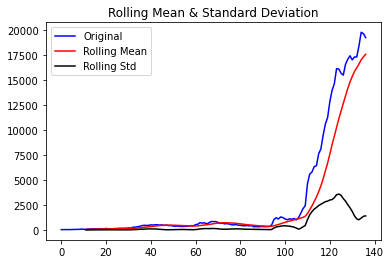

Results of Dickey-Fuller Test:


Test Statistic                  -0.913092
p-value                          0.783630
#Lags Used                      11.000000
Number of Observations Used    125.000000
Critical Value (1%)             -3.483779
Critical Value (5%)             -2.884954
Critical Value (10%)            -2.579257
dtype: float64

In [11]:
#Stationary Olivia

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

dfo1 = pd.DataFrame(dfo)

test_stationarity(dfo1) #p-value = 0.78; therefore, not stationary for Olivia

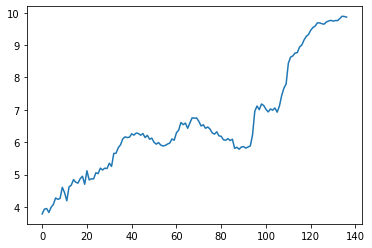

In [12]:
#Rolling average stationarity Olivia

ts_log = np.log(dfo1)
plt.plot(ts_log)

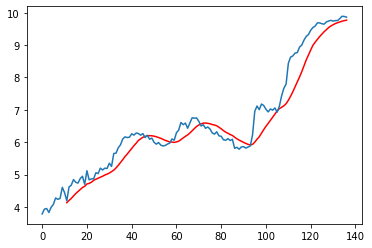

In [13]:
ts_smooth = ts_log.rolling(window = 12).mean()
plt.plot(ts_smooth, color = 'red')
plt.plot(ts_log)
plt.show()

In [14]:
# Case 1: No subtraction
no_sub_ts = ts_smooth
no_sub_ts.dropna(inplace = True)

# Case 2: Yes subtraction
sub_ts = ts_log - ts_smooth
sub_ts.dropna(inplace = True)

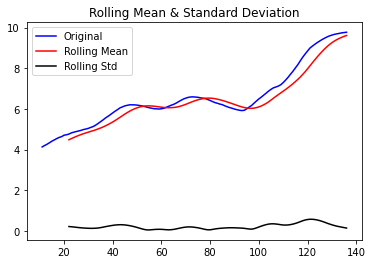

Results of Dickey-Fuller Test:


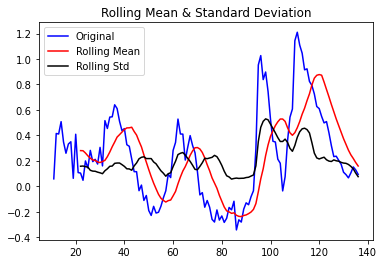

Results of Dickey-Fuller Test:


Test Statistic                  -3.064726
p-value                          0.029276
#Lags Used                       2.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64

In [15]:
# Perform Dickey-Fuller on both
test_stationarity(no_sub_ts)
test_stationarity(sub_ts)

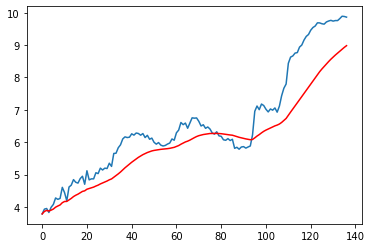

In [16]:
#Exponential weighing to test stationarity Olivia

expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

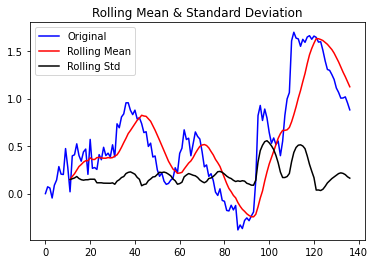

Results of Dickey-Fuller Test:


Test Statistic                  -1.845819
p-value                          0.357963
#Lags Used                       2.000000
Number of Observations Used    134.000000
Critical Value (1%)             -3.480119
Critical Value (5%)             -2.883362
Critical Value (10%)            -2.578407
dtype: float64

In [17]:
exp_ts_diff = ts_log-expwighted_avg
test_stationarity(exp_ts_diff) #data not stationary based on high p-value (0.36)

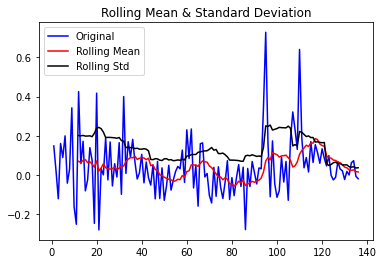

Results of Dickey-Fuller Test:


Test Statistic                -6.840312e+00
p-value                        1.798266e-09
#Lags Used                     1.000000e+00
Number of Observations Used    1.340000e+02
Critical Value (1%)           -3.480119e+00
Critical Value (5%)           -2.883362e+00
Critical Value (10%)          -2.578407e+00
dtype: float64

In [18]:
#Differencing for Stationarity Olivia

ts_diff = ts_log - ts_log.shift()
ts_diff.dropna(inplace = True)

test_stationarity(ts_diff) #very small p-value. Very confident that through differencing, data is stationary

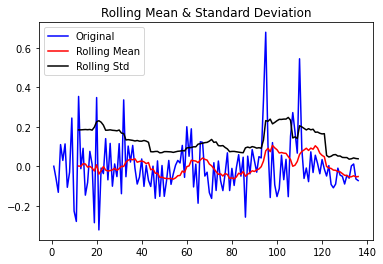

Results of Dickey-Fuller Test:


Test Statistic                -7.119926e+00
p-value                        3.745516e-10
#Lags Used                     1.000000e+00
Number of Observations Used    1.340000e+02
Critical Value (1%)           -3.480119e+00
Critical Value (5%)           -2.883362e+00
Critical Value (10%)          -2.578407e+00
dtype: float64

In [19]:
#Differencing + exponential weighing Olivia

ts_diff_exp_o = ts_diff  - ts_diff.ewm(halflife = 12).mean()
ts_diff_exp_o.dropna(inplace = True)
test_stationarity(ts_diff_exp_o) #Best result thus far (3.75 * 10^-10)

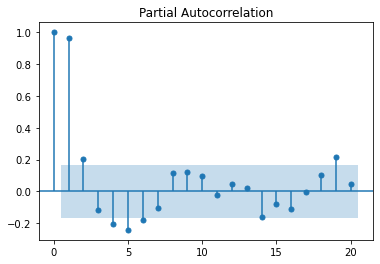

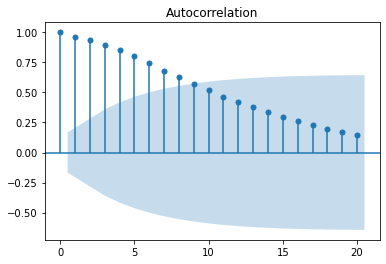

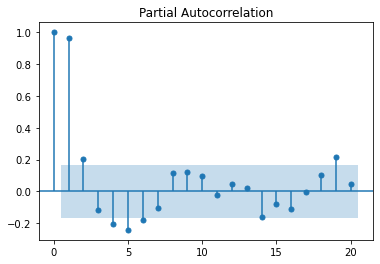

In [20]:
#Newton

dfn = get_evolution('Newton', 'M')

plot_acf(dfn, lags=20)
plot_pacf(dfn, lags=20)

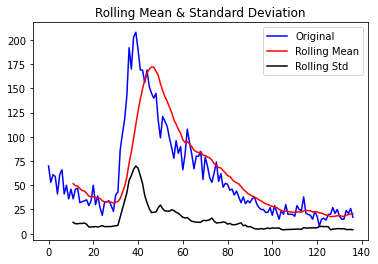

Results of Dickey-Fuller Test:


Test Statistic                  -2.160073
p-value                          0.221054
#Lags Used                       5.000000
Number of Observations Used    131.000000
Critical Value (1%)             -3.481282
Critical Value (5%)             -2.883868
Critical Value (10%)            -2.578677
dtype: float64

In [21]:
dfn1 = pd.DataFrame(dfn)

test_stationarity(dfn1) #p-value = 0.22; therefore, not stationary

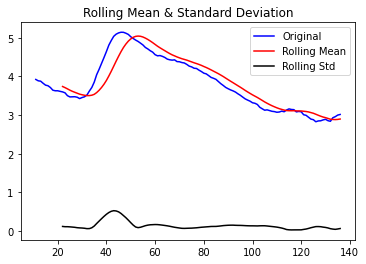

Results of Dickey-Fuller Test:


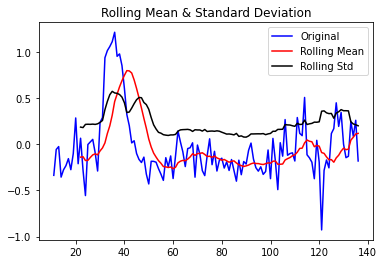

Results of Dickey-Fuller Test:


Test Statistic                  -2.979850
p-value                          0.036820
#Lags Used                       1.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64

In [22]:
#Rolling average stationarity Newton

ts_log_n = np.log(dfn1)
ts_smooth_n = ts_log_n.rolling(window = 12).mean()

# Case 1: No subtraction
no_sub_ts_n = ts_smooth_n
no_sub_ts_n.dropna(inplace = True)

# Case 2: Yes subtraction
sub_ts_n = ts_log_n - ts_smooth_n
sub_ts_n.dropna(inplace = True)

test_stationarity(no_sub_ts_n)
test_stationarity(sub_ts_n)

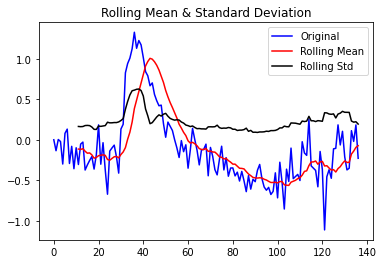

Results of Dickey-Fuller Test:


Test Statistic                  -2.045421
p-value                          0.267019
#Lags Used                       5.000000
Number of Observations Used    131.000000
Critical Value (1%)             -3.481282
Critical Value (5%)             -2.883868
Critical Value (10%)            -2.578677
dtype: float64

In [23]:
#Exponential weighting Newton

expwighted_avg_n = ts_log_n.ewm(halflife=12).mean()

exp_ts_diff_n = ts_log_n-expwighted_avg_n
test_stationarity(exp_ts_diff_n)

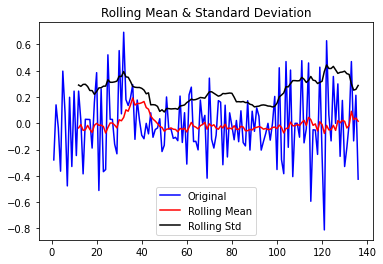

Results of Dickey-Fuller Test:


Test Statistic                -1.684733e+01
p-value                        1.125785e-29
#Lags Used                     0.000000e+00
Number of Observations Used    1.350000e+02
Critical Value (1%)           -3.479743e+00
Critical Value (5%)           -2.883198e+00
Critical Value (10%)          -2.578320e+00
dtype: float64

In [24]:
#Differencing Newton

ts_diff_n = ts_log_n - ts_log_n.shift()
ts_diff_n.dropna(inplace = True)

test_stationarity(ts_diff_n)#p-value 1.13*10^-29. Very confident in stationarity

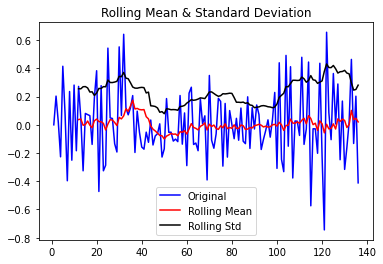

Results of Dickey-Fuller Test:


Test Statistic                -1.695202e+01
p-value                        9.445808e-30
#Lags Used                     0.000000e+00
Number of Observations Used    1.350000e+02
Critical Value (1%)           -3.479743e+00
Critical Value (5%)           -2.883198e+00
Critical Value (10%)          -2.578320e+00
dtype: float64

In [25]:
#Differencing + exponential weighing Newton

ts_diff_exp_n = ts_diff_n - ts_diff_n.ewm(halflife = 12).mean()
ts_diff_exp_n.dropna(inplace = True)
test_stationarity(ts_diff_exp_n)#p-value = 9.45 * 10^-30. Very confident that this is stationary

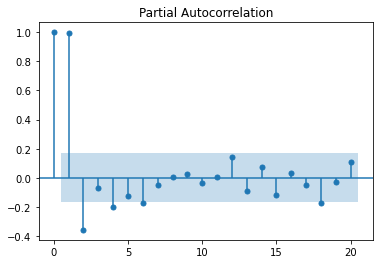

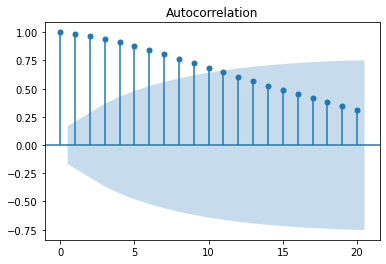

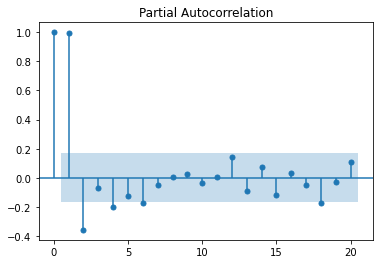

In [26]:
#John

dfj = get_evolution('John', 'M')

plot_acf(dfj, lags=20)
plot_pacf(dfj, lags=20)

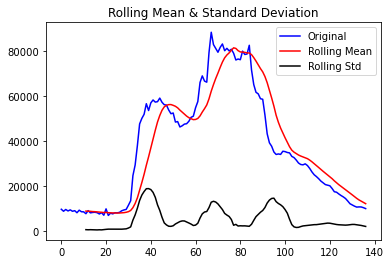

Results of Dickey-Fuller Test:


Test Statistic                  -1.795993
p-value                          0.382453
#Lags Used                       5.000000
Number of Observations Used    131.000000
Critical Value (1%)             -3.481282
Critical Value (5%)             -2.883868
Critical Value (10%)            -2.578677
dtype: float64

In [27]:
dfj1 = pd.DataFrame(dfj)

test_stationarity(dfj1) #p-value = 0.38; therefore, not stationary

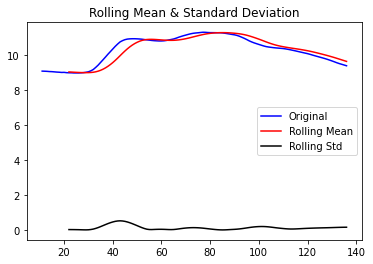

Results of Dickey-Fuller Test:


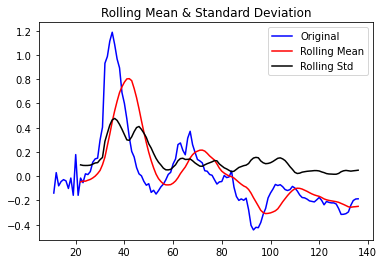

Results of Dickey-Fuller Test:


Test Statistic                  -1.686725
p-value                          0.437965
#Lags Used                      13.000000
Number of Observations Used    112.000000
Critical Value (1%)             -3.490131
Critical Value (5%)             -2.887712
Critical Value (10%)            -2.580730
dtype: float64

In [28]:
#Rolling average stationarity John

ts_log_j = np.log(dfj1)
ts_smooth_j = ts_log_j.rolling(window = 12).mean()

# Case 1: No subtraction
no_sub_ts_j = ts_smooth_j
no_sub_ts_j.dropna(inplace = True)

# Case 2: Yes subtraction
sub_ts_j = ts_log_j - ts_smooth_j
sub_ts_j.dropna(inplace = True)

test_stationarity(no_sub_ts_j)
test_stationarity(sub_ts_j)#p-value too high

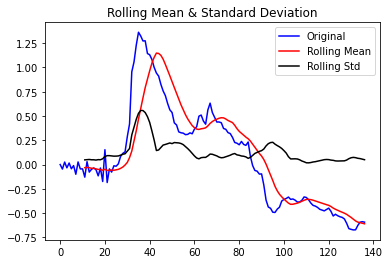

Results of Dickey-Fuller Test:


Test Statistic                  -1.029450
p-value                          0.742372
#Lags Used                      13.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64

In [29]:
#Exponential weighting John

expwighted_avg_j = ts_log_j.ewm(halflife=12).mean()

exp_ts_diff_j = ts_log_j-expwighted_avg_j
test_stationarity(exp_ts_diff_j)#too high p-value

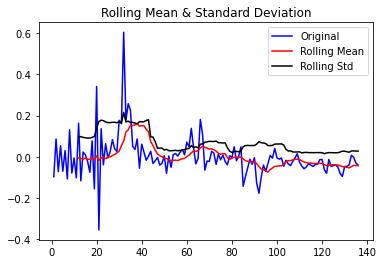

Results of Dickey-Fuller Test:


Test Statistic                  -2.449734
p-value                          0.128188
#Lags Used                      12.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64

In [30]:
#Differencing John

ts_diff_j = ts_log_j - ts_log_j.shift()
ts_diff_j.dropna(inplace = True)

test_stationarity(ts_diff_j)#p-value = 0.12. Still too high

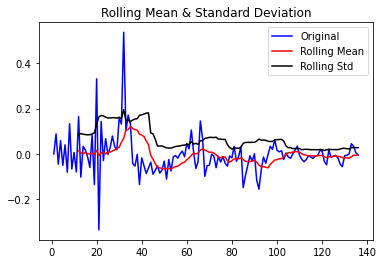

Results of Dickey-Fuller Test:


Test Statistic                  -3.132161
p-value                          0.024263
#Lags Used                      12.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64

In [31]:
#Differencing + exponential weighing John

ts_diff_exp_j = ts_diff_j - ts_diff_j.ewm(halflife = 12).mean()
ts_diff_exp_j.dropna(inplace = True)
test_stationarity(ts_diff_exp_j)#p-value = 0.02. Not bad, but still 98% confident in stationarity.

In [32]:
#Question 1.2

df11 = data[2011].sort_values(by = 'Number', ascending = False).head()
year11 = ['2011', '2011', '2011', '2011', '2011']
df11['Year'] = year11

df12 = data[2012].sort_values(by = 'Number', ascending = False).head()
year12 = ['2012', '2012', '2012', '2012', '2012']
df12['Year'] = year12

df13 = data[2013].sort_values(by = 'Number', ascending = False).head()
year13 = ['2013', '2013', '2013', '2013', '2013']
df13['Year'] = year13

df14 = data[2014].sort_values(by = 'Number', ascending = False).head()
year14 = ['2014', '2014', '2014', '2014', '2014']
df14['Year'] = year14

df15 = data[2015].sort_values(by = 'Number', ascending = False).head()
year15 = ['2015', '2015', '2015', '2015', '2015']
df15['Year'] = year15

df16 = data[2016].sort_values(by = 'Number', ascending = False).head()
year16 = ['2016', '2016', '2016', '2016', '2016']
df16['Year'] = year16

df = [df11, df12, df13, df14, df15, df16]

In [33]:
result = pd.concat(df)

In [34]:
result.reset_index(inplace = True)

result

,First name,Gender,Number,Year
0,Sophia,F,21833,2011
1,Jacob,M,20356,2011
2,Isabella,F,19891,2011
3,Mason,M,19503,2011
4,Emma,F,18791,2011
5,Sophia,F,22292,2012
6,Emma,F,20922,2012
7,Isabella,F,19089,2012
8,Jacob,M,19061,2012
9,Mason,M,18961,2012


In [35]:
result.set_index('Year')

,First name,Gender,Number
Year,,,
2011,Sophia,F,21833
2011,Jacob,M,20356
2011,Isabella,F,19891
2011,Mason,M,19503
2011,Emma,F,18791
2012,Sophia,F,22292
2012,Emma,F,20922
2012,Isabella,F,19089
2012,Jacob,M,19061


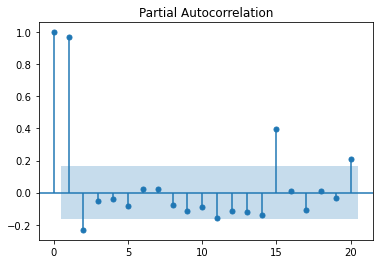

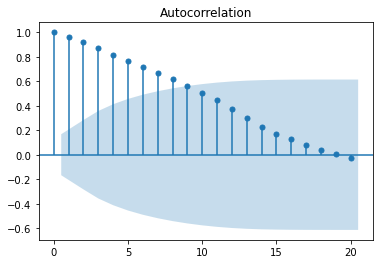

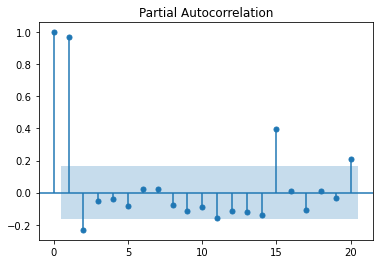

In [36]:
#Stationarity of Emma - Top name

dfe = get_evolution('Emma', 'F')

plot_acf(dfe, lags=20)
plot_pacf(dfe, lags=20)

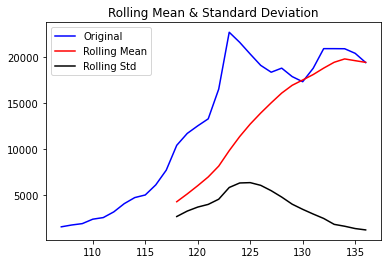

Results of Dickey-Fuller Test:


Test Statistic                 -1.414891
p-value                         0.575117
#Lags Used                      1.000000
Number of Observations Used    28.000000
Critical Value (1%)            -3.688926
Critical Value (5%)            -2.971989
Critical Value (10%)           -2.625296
dtype: float64

In [37]:
dfe1 = pd.DataFrame(dfe)
dfe1 = dfe1.tail(n = 30)
test_stationarity(dfe1) #p-value = 0.58; therefore, not stationary

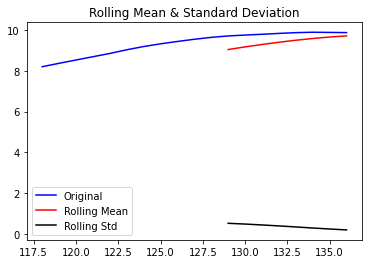

Results of Dickey-Fuller Test:


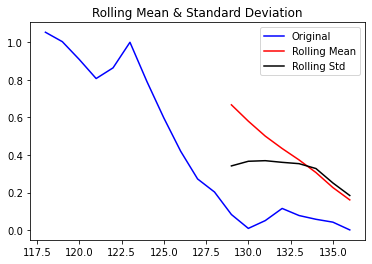

Results of Dickey-Fuller Test:


Test Statistic                 -2.658737
p-value                         0.081455
#Lags Used                      7.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64

In [38]:
#Rolling average stationarity Emma

ts_log_e = np.log(dfe1)
ts_smooth_e = ts_log_e.rolling(window = 12).mean()

# Case 1: No subtraction
no_sub_ts_e = ts_smooth_e
no_sub_ts_e.dropna(inplace = True)

# Case 2: Yes subtraction
sub_ts_e = ts_log_e - ts_smooth_e
sub_ts_e.dropna(inplace = True)

test_stationarity(no_sub_ts_e)
test_stationarity(sub_ts_e)#p-value = 0.08. Still too high

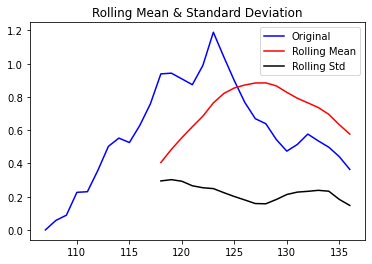

Results of Dickey-Fuller Test:


Test Statistic                 -1.902488
p-value                         0.330892
#Lags Used                      1.000000
Number of Observations Used    28.000000
Critical Value (1%)            -3.688926
Critical Value (5%)            -2.971989
Critical Value (10%)           -2.625296
dtype: float64

In [39]:
#Exponential weighting Emma

expwighted_avg_e = ts_log_e.ewm(halflife=12).mean()

exp_ts_diff_e = ts_log_e-expwighted_avg_e
test_stationarity(exp_ts_diff_e)#p-value = 0.33. Still not stationary

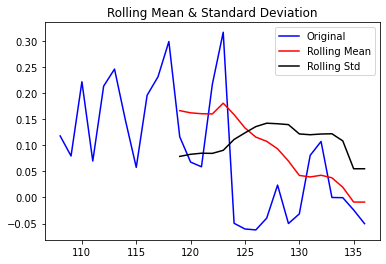

Results of Dickey-Fuller Test:


Test Statistic                 -2.703756
p-value                         0.073391
#Lags Used                      0.000000
Number of Observations Used    28.000000
Critical Value (1%)            -3.688926
Critical Value (5%)            -2.971989
Critical Value (10%)           -2.625296
dtype: float64

In [40]:
#Differencing Emma

ts_diff_e = ts_log_e - ts_log_e.shift()
ts_diff_e.dropna(inplace = True)

test_stationarity(ts_diff_e)#p-value = 0.07. Still too high

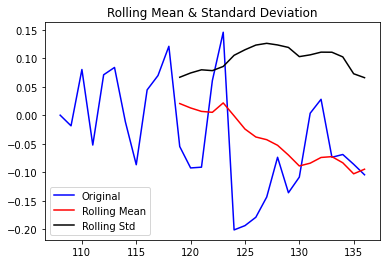

Results of Dickey-Fuller Test:


Test Statistic                 -3.281603
p-value                         0.015721
#Lags Used                      0.000000
Number of Observations Used    28.000000
Critical Value (1%)            -3.688926
Critical Value (5%)            -2.971989
Critical Value (10%)           -2.625296
dtype: float64

In [41]:
#Differencing + exponential weighing Emma

ts_diff_exp_e = ts_diff_e - ts_diff_e.ewm(halflife = 12).mean()
ts_diff_exp_e.dropna(inplace = True)
test_stationarity(ts_diff_exp_e)#p-value = 0.015. Most stationary example

In [42]:
ts_diff_exp_e = ts_diff_exp_e.rename(columns = {0 : 'Number'})

In [43]:
ts_diff_exp_e['Year'] = list(range(1988, 2017))
ts_diff_exp_e.reset_index(inplace = True, drop = True)

In [44]:
ts_diff_exp_e['Year'] = pd.to_datetime(ts_diff_exp_e['Year'], format = '%Y')
ts_diff_exp_e = ts_diff_exp_e.set_index('Year')

In [45]:
ts_diff_exp_e

,Number
Year,
1988-01-01,0.000000
1989-01-01,-0.018691
1990-01-01,0.080093
1991-01-01,-0.052399
1992-01-01,0.070852
1993-01-01,0.083717
1994-01-01,-0.011722
1995-01-01,-0.086933
1996-01-01,0.044338


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JA

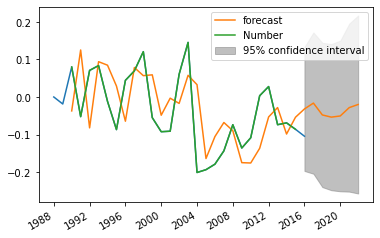

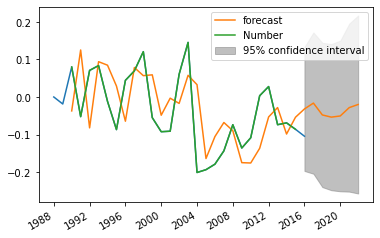

In [46]:
dfe1_train = ts_diff_exp_e.iloc[:-1]
dfe1_test = ts_diff_exp_e.iloc[-1:]

model = ARIMA(dfe1_train, order=(5, 2, 1))
res = model.fit(disp=-1)

fig, ax = plt.subplots()
ax.plot(ts_diff_exp_e)

res.plot_predict('1990', '2022', ax=ax)

In [47]:
#Next Popular Name - Olivia (see part 1 for stationarity)

ts_diff_exp_o = ts_diff_exp_o.tail(n = 30)
ts_diff_exp_o

,0
107,0.272027
108,0.172457
109,0.066389
110,0.544946
111,0.089862
112,-0.061854
113,-0.008941
114,-0.078073
115,0.073029
116,-0.031817


In [48]:
ts_diff_exp_o = ts_diff_exp_o.rename(columns = {0 : 'Number'})

In [49]:
ts_diff_exp_o['Year'] = list(range(1987, 2017))
ts_diff_exp_o.reset_index(inplace = True, drop = True)

In [50]:
ts_diff_exp_o['Year'] = pd.to_datetime(ts_diff_exp_o['Year'], format = '%Y')
ts_diff_exp_o = ts_diff_exp_o.set_index('Year')

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JA

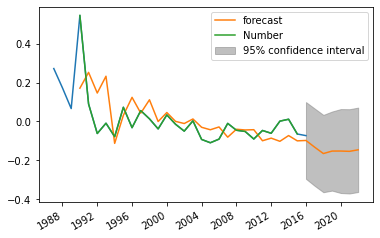

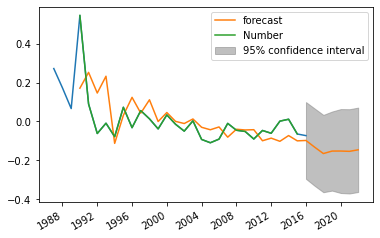

In [65]:
dfo1_train = ts_diff_exp_o.iloc[:-1]
dfo1_test = ts_diff_exp_o.iloc[-1:]

model = ARIMA(dfo1_train, order=(4, 1, 1))
res = model.fit(disp=-1)

fig, ax = plt.subplots()
ax.plot(ts_diff_exp_o)

res.plot_predict('1990', '2022', ax=ax)

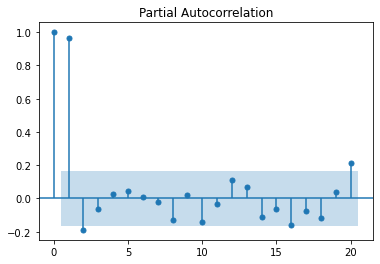

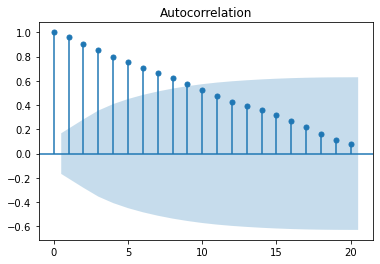

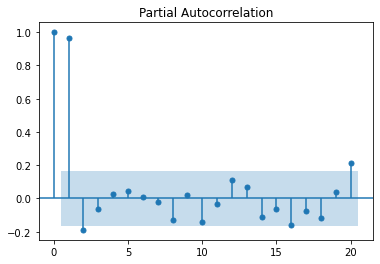

In [52]:
#Third most popular name - Noah

dfno = get_evolution('Noah', 'M')

plot_acf(dfno, lags=20)
plot_pacf(dfno, lags=20)

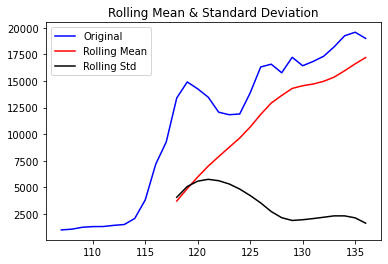

Results of Dickey-Fuller Test:


Test Statistic                 -1.809516
p-value                         0.375747
#Lags Used                      5.000000
Number of Observations Used    24.000000
Critical Value (1%)            -3.737709
Critical Value (5%)            -2.992216
Critical Value (10%)           -2.635747
dtype: float64

In [53]:
dfno1 = pd.DataFrame(dfno)
dfno1 = dfno1.tail(n = 30)
test_stationarity(dfno1) #p-value = 0.38. Not stationary

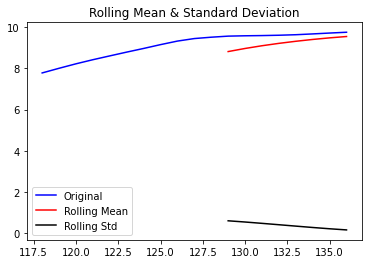

Results of Dickey-Fuller Test:


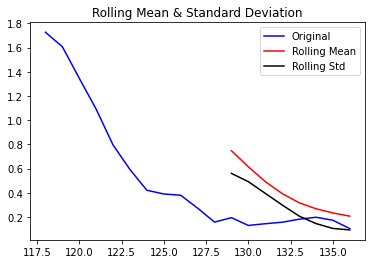

Results of Dickey-Fuller Test:


Test Statistic                 -4.967435
p-value                         0.000026
#Lags Used                      0.000000
Number of Observations Used    18.000000
Critical Value (1%)            -3.859073
Critical Value (5%)            -3.042046
Critical Value (10%)           -2.660906
dtype: float64

In [54]:
#Rolling average stationarity Noah

ts_log_no = np.log(dfno1)
ts_smooth_no = ts_log_no.rolling(window = 12).mean()

# Case 1: No subtraction
no_sub_ts_no = ts_smooth_no
no_sub_ts_no.dropna(inplace = True)

# Case 2: Yes subtraction
sub_ts_no = ts_log_no - ts_smooth_no
sub_ts_no.dropna(inplace = True)

test_stationarity(no_sub_ts_no)
test_stationarity(sub_ts_no)#p-value is extremely small. 99% confident that this is stationary

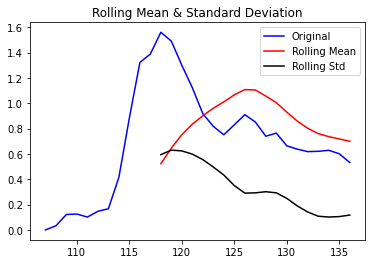

Results of Dickey-Fuller Test:


Test Statistic                 -2.440270
p-value                         0.130692
#Lags Used                      5.000000
Number of Observations Used    24.000000
Critical Value (1%)            -3.737709
Critical Value (5%)            -2.992216
Critical Value (10%)           -2.635747
dtype: float64

In [55]:
#Exponential weighting Noah

expwighted_avg_no = ts_log_no.ewm(halflife=12).mean()

exp_ts_diff_no = ts_log_no-expwighted_avg_no
test_stationarity(exp_ts_diff_no)#p-value = 0.13. Not stationary this way

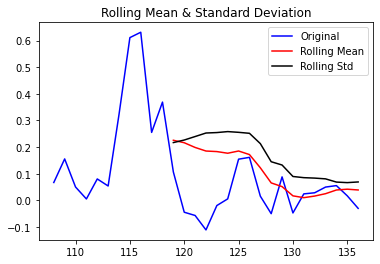

Results of Dickey-Fuller Test:


Test Statistic                 -2.488982
p-value                         0.118178
#Lags Used                      3.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64

In [56]:
#Differencing Noah

ts_diff_no = ts_log_no - ts_log_no.shift()
ts_diff_no.dropna(inplace = True)

test_stationarity(ts_diff_no)#p-value = 0.11. Too high

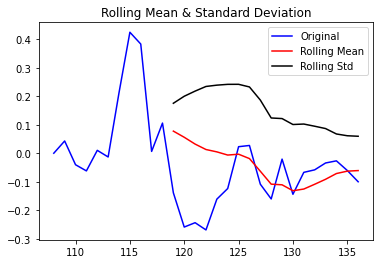

Results of Dickey-Fuller Test:


Test Statistic                 -2.228561
p-value                         0.196043
#Lags Used                      4.000000
Number of Observations Used    24.000000
Critical Value (1%)            -3.737709
Critical Value (5%)            -2.992216
Critical Value (10%)           -2.635747
dtype: float64

In [57]:
#Differencing + exponential weighing Noah

ts_diff_exp_no = ts_diff_no - ts_diff_no.ewm(halflife = 12).mean()
ts_diff_exp_no.dropna(inplace = True)
test_stationarity(ts_diff_exp_no)#p-value = 0.20. Not stationary

In [58]:
sub_ts_no = sub_ts_no.rename(columns = {0 : 'Number'})

In [59]:
sub_ts_no['Year'] = list(range(1998, 2017))
sub_ts_no.reset_index(inplace = True, drop = True)

In [60]:
sub_ts_no['Year'] = pd.to_datetime(sub_ts_no['Year'], format = '%Y')
sub_ts_no = sub_ts_no.set_index('Year')

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JA

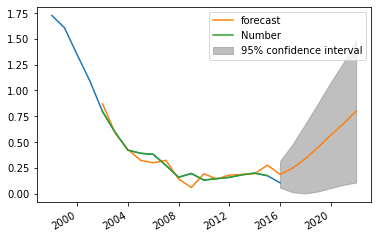

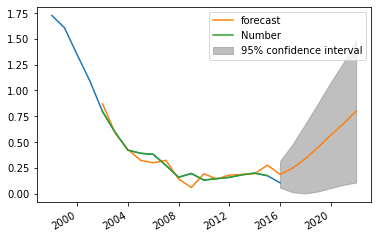

In [62]:
dfno_train = sub_ts_no.iloc[:-1]
dfno_test = sub_ts_no.iloc[-1:]

model = ARIMA(dfno_train, order=(5, 2, 0))
res = model.fit(disp=-1)

fig, ax = plt.subplots()
ax.plot(sub_ts_no)

res.plot_predict('2002', '2022', ax=ax)